Building Your First Neural Network

# Objectives

- Get an overview of how you can build simple feed-forward neural networks in Python
- Learn more about the training process
- Understand the importance of training and validation data
- Build your very first neural network

# Problem overview

We will use the MNIST dataset (http://yann.lecun.com/exdb/mnist/) to build a simple feed-forward neural network capable of recognizing hand-written numbers between 0 and 9. Below you can see an example of a hand-written variation of the number 5.

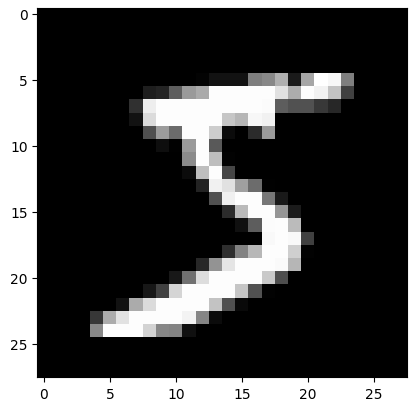

It is easy to see that using traditional image processing techniques for this problem would be cumbersome, as the development of any such method would require a lot of time and would most likely underperform in the real world.

Therefore, we will use deep learning, more precisely a simple neural network architecture that will learn the most important features on its own. This way, there will be no need to think about what kind of features are the most important for this given problem, as all of this will be taken care of by the network automatically.

# The MNIST dataset

The MNIST dataset contains 70,000 images (60,000 for training and 10,000 for testing) and has examples for all of the single digit numbers (0 to 9). All of the images are grayscale: the digits are drawn in black while the background pixels are white. Lastly, each number has roughly the same number of images and each image only contains one number.


We will start with downloading the dataset. If you look at the website of the dataset (http://yann.lecun.com/exdb/mnist/), you can see that there are 4 files to download:
- train-images-idx3-ubyte.gz (training images)
- train-labels-idx1-ubyte.gz (training labels)
- t10k-images-idx3-ubyte.gz (test images)
- t10k-labels-idx1-ubyte.gz (test labels).

To download these files, run the cell below.


In [ ]:
# This command is only used to guarantee that running the cell multiple times will not result in any unexpected behaviour.
! rm -rf data_raw

# We start by downloading the training images and their corresponding labels.
! wget -P data_raw http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
! wget -P data_raw http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

# Then, we download the test data.
! wget -P data_raw http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
! wget -P data_raw http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

# This command is only used to guarantee that running the cell multiple times will not result in any unexpected behaviour.
! rm -rf data

# We create the "data" folder, where will store the dataset.
! mkdir data

# We unzip the training images and labels into the "data/train" folder.
# The images and their corresponding labels will be stored inside the "images-ubyte" and "labels-ubyte" subfolders, respectively.
! mkdir data/train
! gunzip -c data_raw/train-images-idx3-ubyte.gz > data/train/images-ubyte
! gunzip -c data_raw/train-labels-idx1-ubyte.gz > data/train/labels-ubyte

# We unzip the training images and labels into the "data/test" folder.
# The images and their corresponding labels will be stored inside the "images-ubyte" and "labels-ubyte" subfolders, respectively.
! mkdir data/test
! gunzip -c data_raw/t10k-images-idx3-ubyte.gz > data/test/images-ubyte
! gunzip -c data_raw/t10k-labels-idx1-ubyte.gz > data/test/labels-ubyte


We will use the idx2numpy Python library to convert the original ubyte files into NumPy arrays. Running the cell below installs the library.

In [ ]:
! pip install idx2numpy

In [ ]:
import numpy as np
import idx2numpy

# We implement a function to handle the ubyte to NumPy conversion for us.
def load_ubyte_file(file_path):
  return idx2numpy.convert_from_file(file_path)

# Then, we start by converting the input images to NumPy arrays.
X_train = load_ubyte_file("data/train/images-ubyte")
y_train = load_ubyte_file("data/train/labels-ubyte")

# After the images, we also convert the labels to NumPy format.
X_val= load_ubyte_file("data/test/images-ubyte")
y_val = load_ubyte_file("data/test/labels-ubyte")

# To make sure that everything is correct and also to get an overview of the
# dimensions of the data, we print out the shapes of each variable.
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)


In [ ]:
# As an extra safety measure, we also visualize the first and second items
# of the training dataset.
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap="gray")
plt.title(y_train[0])
plt.show()

In [ ]:
plt.imshow(X_train[1], cmap="gray")
plt.title(y_train[1])
plt.show()

Now, let us look at other details of the dataset, such as the data type and minimum and maximum values.

In [ ]:
X_train.dtype

In [ ]:
X_train.min()

In [ ]:
X_train.max()

In [ ]:
y_train.dtype

In [ ]:
y_train.min()

In [ ]:
y_train.max()

# Pre-processing the images & labels

Although everything looks great so far, there is still an additional transformation that we need to do. That is, we need to flatten the images (28 x 28 pixels) into a vector (784 elements in total). This is because we are going to use a simple feed-forward neural network, which can only receive vectors as its input. An example of the flatten operation can be seen in the picture below.


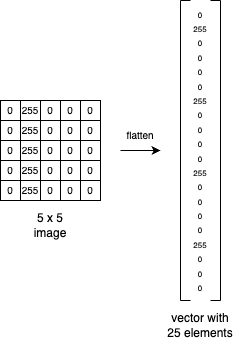

Apart from the flattening of the images, we will also normalize the pixel values so that after the transformation, each pixel can only have a value between 0 and 1 (instead of the original [0,255] range).

In [ ]:
X_train = X_train.reshape(60000, 784)
X_val = X_val.reshape(10000, 784)

In [ ]:
X_train = X_train / 255
X_val = X_val / 255

In [ ]:
# Notice that after the transformation the type of the inputs will change from integer to float.
X_train.dtype

In [ ]:
X_train.min()

In [ ]:
X_train.max()

We will also need to transform the class labels as well. That is because we will use the categorical crossentropy loss function when training the neural network, which requires that the output labels are one-hot encoded.

This means that we will need to transform each class label (0 to 9) to a vector with 10 elements (the number of classes), where each element will be either 0 or 1. The given element will be 1 if the given column corresponds to the class label (e.g. 1st column for the number 0 and 6th column for the number 5) and 0 otherwise.

In [ ]:
import tensorflow.keras as keras

# We set the random seed to 0
keras.utils.set_random_seed(0)

n_classes = 10

# We apply one-hot encoding using the to_categorical Keras function.
y_train = keras.utils.to_categorical(y_train, n_classes)
y_val = keras.utils.to_categorical(y_val, n_classes)

In [ ]:
# We can see that after the transformation, each row has been transformed.
# Notice how the first element, which was previously 5, is now all zeroes
# except for the 6th column. The same logic is true for the other rows as
# well.
y_train[0:5]

# Building the network

Now, we can finally start building our neural network. For this, we will use the Sequential class of the keras library, which makes building neural networks really easy.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# The neural network will have 2 hidden layers in total, each with 512-512
# neurons.
model = Sequential([
    Dense(units=128, activation="relu", input_shape=(784,)),
    Dense(units = 64, activation="relu"),
    Dense(units = n_classes, activation="softmax")
])

# Lastly, we also need to compile the model, which is the same as saying
# that we specify the loss and metric used during training.
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# We can now print the summary of the model, which tells us how many
# layers there are in the model and how many neurons each one has.
model.summary()

In [ ]:
# We can now train the model using the .fit() function.
history = model.fit(
    X_train, y_train, epochs=5, verbose=1, validation_data=(X_val, y_val)
)

In [ ]:
# After the training is done, it is time to check the training and validation
# losses. Both seem to have decreased over the epochs, which is a good sign.
plt.plot(history.history["loss"], "*-")
plt.plot(history.history["val_loss"], "*-")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

In [ ]:
# If we check the accuracies, we will see a similar trend:
# both the training and validation accuracies have increased
# during training.
plt.plot(history.history["accuracy"], "*-")
plt.plot(history.history["val_accuracy"], "*-")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()